<a href="https://colab.research.google.com/github/alinorouziani/CNNImageClassificationPytorch/blob/main/CNNImageClassificationPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

**Getting the data ready:**

In [3]:
train_data = datasets.FashionMNIST(
    root= 'data',
    train= True,
    transform= ToTensor(),
    download= True,
)
test_data = datasets.FashionMNIST(
    root= 'data',
    train= False,
    transform= ToTensor(),
    download= True
)

100%|██████████| 26421880/26421880 [00:12<00:00, 2143852.94it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 198405.13it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3620458.94it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19629342.72it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size= BATCH_SIZE, shuffle= True)
test_dataloader = DataLoader(test_data, batch_size= BATCH_SIZE, shuffle= True)

In [5]:
class_names = test_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [6]:
from timeit import default_timer as timer
def timing(start, end, device= None):
  total_time = end-start
  print(f"Train time on {device}: {total_time:.2f} seconds")
  return total_time

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

**Building a model**

In [7]:
class FashionMNISTModel(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*5*5, out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [8]:
model = FashionMNISTModel(input_shape=1,
                          hidden_units=20,
                          output_shape= len(class_names))
model

FashionMNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 20, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(2, 2), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=500, out_features=10, bias=True)
  )
)

**We need to create a dummy to find out how many hidden units in the classifer should be.**

In [36]:
rand_img_tensor = torch.randn(size= (1,28,28))
model(rand_img_tensor.unsqueeze(0))

tensor([[-1.1547e-02,  7.3123e-02, -2.5014e-02, -8.1999e-03, -1.9027e-03,
         -6.7167e-06,  5.4570e-02, -3.2992e-02, -3.8166e-02,  3.5365e-02]],
       grad_fn=<AddmmBackward0>)

Step 1: Start by defining the input feature size, setting `in_features = hidden_units * 0`.
Step 2: Next, create a dummy input tensor and feed it into the model.
Step 3: If the tensor shape is incompatible with the model's expected dimensions, you will encounter an error message specifying the mismatched shape.



**Creating a model trainer**

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params= model.parameters(), lr= 0.1)

In [38]:
from tqdm.auto import tqdm
torch.manual_seed(123)
epochs = 3
train_time_start = timer()
for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}')
  train_loss = 0
  accuracy_train = 0
  for batch, (x, y) in enumerate(train_dataloader):
    model.train()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    accuracy_train += accuracy_fn(y, y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 400 == 0:
      print(f'looked at {batch*len(x)}/ {len(train_dataloader.dataset)}')
  train_loss /= len(train_dataloader)
  accuracy_train /= len(train_dataloader)
  test_loss = 0
  accuracy_test = 0
  model.eval()
  with torch.inference_mode():
    for x, y in test_dataloader:
      test_pred = model(x)
      test_loss += loss_fn(test_pred, y)
      accuracy_test += accuracy_fn(y, test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    accuracy_test /= len(test_dataloader)
  print(f"\nTrain loss: {train_loss:.5f}, Train acc: {accuracy_train:.5f}|Test loss: {test_loss:.5f}, Test acc: {accuracy_test:.2f}%\n")
train_time_end = timer()
total_train_time = timing(start= train_time_start, end= train_time_end, device= 'cpu')

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
looked at 0/ 60000
looked at 12800/ 60000
looked at 25600/ 60000
looked at 38400/ 60000
looked at 51200/ 60000

Train loss: 0.64527, Train acc: 76.38167|Test loss: 0.43055, Test acc: 84.44%

Epoch: 1
looked at 0/ 60000
looked at 12800/ 60000
looked at 25600/ 60000
looked at 38400/ 60000
looked at 51200/ 60000

Train loss: 0.39097, Train acc: 85.64500|Test loss: 0.41820, Test acc: 84.65%

Epoch: 2
looked at 0/ 60000
looked at 12800/ 60000
looked at 25600/ 60000
looked at 38400/ 60000
looked at 51200/ 60000

Train loss: 0.35272, Train acc: 87.15000|Test loss: 0.37749, Test acc: 86.48%

Train time on cpu: 241.32 seconds


**Let's see if GPU is better for this model.**

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
from tqdm.auto import tqdm
epoches=3
model.to(device)
train_time_start = timer()
for epoch in tqdm(range(epoches)):
  train_loss, train_acc=0,0
  test_loss, test_acc = 0,0
  model.train()
  for batch, (x, y) in enumerate(train_dataloader):
    x, y= x.to(device), y.to(device)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 400 == 0:
      print(f'looked at {batch*len(x)}/ {len(train_dataloader.dataset)}')
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  model.eval()
  with torch.inference_mode():
    for x, y in test_dataloader:
      x, y = x.to(device), y.to(device)
      test_pred = model(x)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  print(f"\nTrain loss: {train_loss:.5f}, Train acc: {train_acc:.5f}|Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
train_time_end = timer()
total_train_time = timing(start= train_time_start, end= train_time_end, device= 'cpu')


  0%|          | 0/3 [00:00<?, ?it/s]

looked at 0/ 60000
looked at 12800/ 60000
looked at 25600/ 60000
looked at 38400/ 60000
looked at 51200/ 60000

Train loss: 0.39061, Train acc: 85.74500|Test loss: 0.40632, Test acc: 85.14%

looked at 0/ 60000
looked at 12800/ 60000
looked at 25600/ 60000
looked at 38400/ 60000
looked at 51200/ 60000

Train loss: 0.34823, Train acc: 87.49333|Test loss: 0.35275, Test acc: 87.30%

looked at 0/ 60000
looked at 12800/ 60000
looked at 25600/ 60000
looked at 38400/ 60000
looked at 51200/ 60000

Train loss: 0.32186, Train acc: 88.25167|Test loss: 0.34866, Test acc: 86.95%

Train time on cpu: 36.19 seconds


In [40]:
def make_predictions(model, data, device=device):
  pred_probs=[]
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0).to(device)
      pred_logits = model(sample)
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)

In [45]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=16):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(model= model, data= test_samples)
pred_classes = pred_probs.argmax(dim=1)

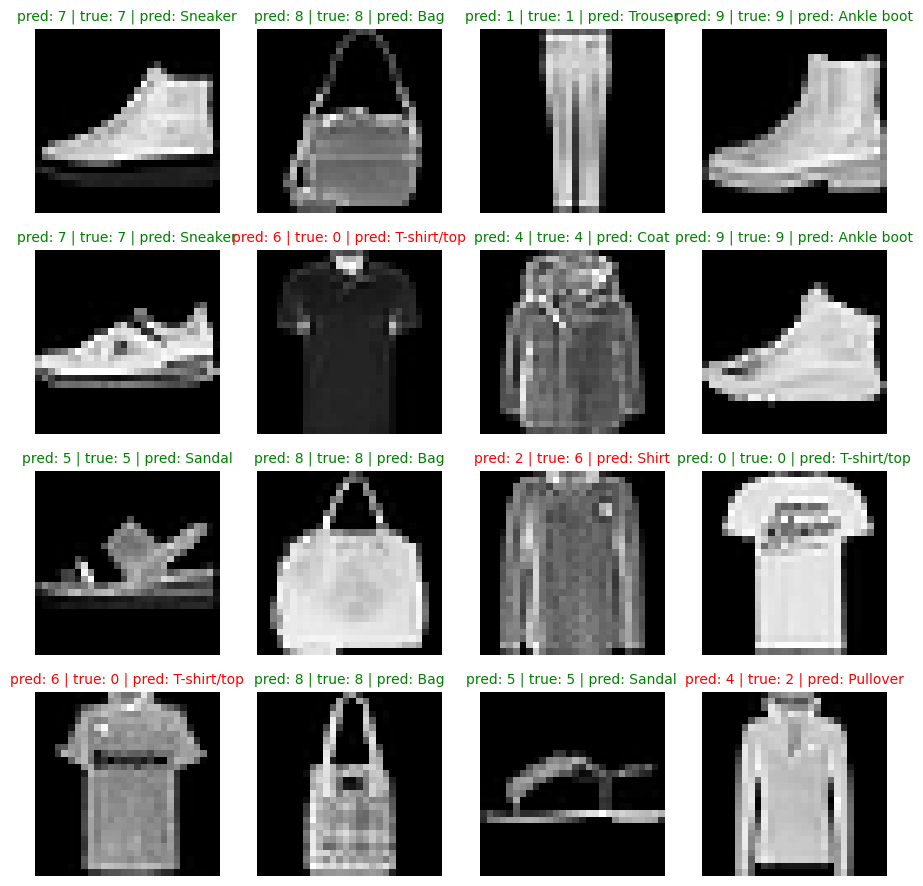

In [48]:
plt.figure(figsize=(11,11))
nrows=4
ncols=4
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap='gray')
  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]]
  title = (f'pred: {pred_classes[i]} | true: {test_labels[i]} | pred: {truth_label}')
  if pred_label == truth_label:
    plt.title(title, fontsize=10, c='g')
  else:
    plt.title(title, fontsize=10, c='r')
  plt.axis('OFF')